In [7]:
!pip install datasets 'tensorflow==2.15'

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, Layer, TextVectorization, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
%matplotlib inline


# Load TweetEval dataset (irony subset)
data = load_dataset("tweet_eval", "irony")

# Preprocess data
train_texts = data["train"]["text"]
train_labels = tf.keras.utils.to_categorical(np.array(data["train"]["label"]), num_classes=2)

test_texts = data["test"]["text"]
test_labels = tf.keras.utils.to_categorical(np.array(data["test"]["label"]), num_classes=2)

# Debugging: Check label distributions
print(f"Training labels distribution: {np.sum(train_labels, axis=0)}")
print(f"Test labels distribution: {np.sum(test_labels, axis=0)}")

# Train a Word2Vec model using gensim
sentences = [text.split() for text in train_texts]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")

# Create an embedding matrix
word2vec_vocab = word2vec_model.wv.index_to_key
embedding_matrix = np.zeros((len(word2vec_vocab)+1, 300))
word_index_map = {word: idx + 1 for idx, word in enumerate(word2vec_vocab)}
for word, idx in word_index_map.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

# Map tokens to Word2Vec indices
def map_to_word2vec_indices(text, word_index_map):
    tokens = text.split()
    return [word_index_map.get(token, 0) for token in tokens]

# Create TensorFlow datasets
def create_tf_dataset(texts, labels, word_index_map, max_length=100):
    # Tokenize texts
    tokenized_texts = [map_to_word2vec_indices(text, word_index_map) for text in texts]
    # Pad sequences
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts, maxlen=max_length, padding='post')
    # Create TensorFlow dataset
    return tf.data.Dataset.from_tensor_slices((padded_texts, labels))

# Create datasets
train_dataset = create_tf_dataset(train_texts, train_labels, word_index_map)
test_dataset = create_tf_dataset(test_texts, test_labels, word_index_map)

# Debugging: Check dataset shapes
for batch in train_dataset.take(1):
    print(f"Sample input shape: {batch[0].shape}, Sample label shape: {batch[1].shape}")

# Prepare datasets for training
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(256).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE)



Training labels distribution: [1417. 1445.]
Test labels distribution: [473. 311.]
Sample input shape: (100,), Sample label shape: (2,)


In [9]:

def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] * np.arange(d_model)[np.newaxis, :] * (1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model)))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)

class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output, attention_scores = self.att(inputs, inputs, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), attention_scores

In [10]:

# Custom embedding layer
class PretrainedEmbedding(Layer):
    def __init__(self, embedding_matrix):
        super(PretrainedEmbedding, self).__init__()
        self.embedding = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            trainable=False
        )

    def call(self, x):
        return self.embedding(x)

# Model Hyperparameters
d_model = 300
num_heads = 8
ff_dim = 1024
num_classes = 2

# Build the Model
inputs = Input(shape=(100,))
embedding_layer = PretrainedEmbedding(embedding_matrix)
embeddings = embedding_layer(inputs)

# Add Transformer Blocks
transformer_block1 = TransformerBlock(d_model, num_heads, ff_dim)
transformer_block2 = TransformerBlock(d_model, num_heads, ff_dim)
transformer_block3 = TransformerBlock(d_model, num_heads, ff_dim)
x, attn_weights1 = transformer_block1(embeddings)
x = BatchNormalization()(x)
x, attn_weights2 = transformer_block2(x)
x = BatchNormalization()(x)
x, attn_weights3 = transformer_block3(x)
x = BatchNormalization()(x)

# Classification Head
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dropout(0.15)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.15)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

# Model Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 pretrained_embedding_2 (Pr  (None, 100, 300)          3768300   
 etrainedEmbedding)                                              
                                                                 
 transformer_block_6 (Trans  ((None, 100, 300),        3504424   
 formerBlock)                 (None, 8, 100, 100))               
                                                                 
 batch_normalization_6 (Bat  (None, 100, 300)          1200      
 chNormalization)                                                
                                                                 
 transformer_block_7 (Trans  ((None, 100, 300),        3504424   
 formerBlock)                 (None, 8, 100, 100))         

In [11]:

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Add EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the Model
model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

# Evaluate the Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy}")


Epoch 1/50
12/12 [==============================] - 12s 220ms/step - loss: 0.7186 - accuracy: 0.5161 - val_loss: 0.7049 - val_accuracy: 0.5089
Epoch 2/50
12/12 [==============================] - 2s 163ms/step - loss: 0.7041 - accuracy: 0.5255 - val_loss: 0.7436 - val_accuracy: 0.3967
Epoch 3/50
12/12 [==============================] - 2s 162ms/step - loss: 0.7005 - accuracy: 0.5210 - val_loss: 0.7522 - val_accuracy: 0.3967
Epoch 4/50
12/12 [==============================] - 2s 165ms/step - loss: 0.6918 - accuracy: 0.5342 - val_loss: 0.6991 - val_accuracy: 0.5293
Epoch 5/50
12/12 [==============================] - 2s 161ms/step - loss: 0.6967 - accuracy: 0.5217 - val_loss: 0.7364 - val_accuracy: 0.5026
Epoch 6/50
12/12 [==============================] - 2s 162ms/step - loss: 0.7020 - accuracy: 0.5210 - val_loss: 0.8248 - val_accuracy: 0.3967
Epoch 7/50
12/12 [==============================] - 2s 161ms/step - loss: 0.6954 - accuracy: 0.5412 - val_loss: 0.8943 - val_accuracy: 0.3967
Epoch

In [12]:

# Manual Testing
ironic_phrases = ["Oh great, another Monday.", "This is exactly what I needed right now."]
non_ironic_phrases = ["I love sunny weather.", "This meal is delicious."]

test_phrases = ironic_phrases + non_ironic_phrases

test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    [map_to_word2vec_indices(text, word_index_map) for text in test_phrases], maxlen=100, padding='post'
)

# Debugging: Check dimensions of manual test input
print(f"Manual test data shape: {test_sequences.shape}")

predictions = model.predict(test_sequences)
for phrase, pred in zip(test_phrases, predictions):
    label = "Ironic" if np.argmax(pred) == 1 else "Non-Ironic"
    print(f"Phrase: '{phrase}' - Predicted Label: {label}")


Manual test data shape: (4, 100)
1/1 [==============================] - 0s 450ms/step
Phrase: 'Oh great, another Monday.' - Predicted Label: Ironic
Phrase: 'This is exactly what I needed right now.' - Predicted Label: Non-Ironic
Phrase: 'I love sunny weather.' - Predicted Label: Non-Ironic
Phrase: 'This meal is delicious.' - Predicted Label: Ironic


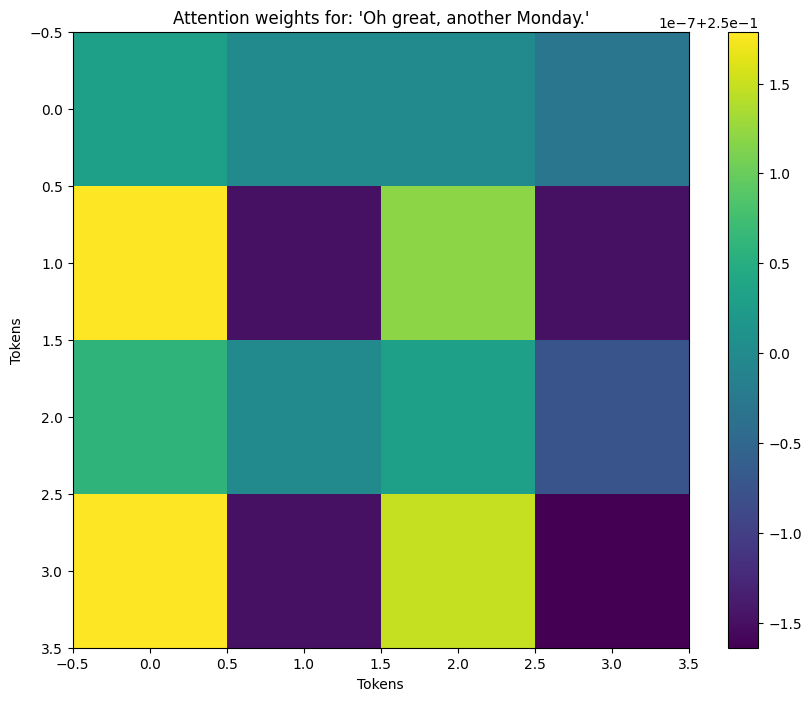

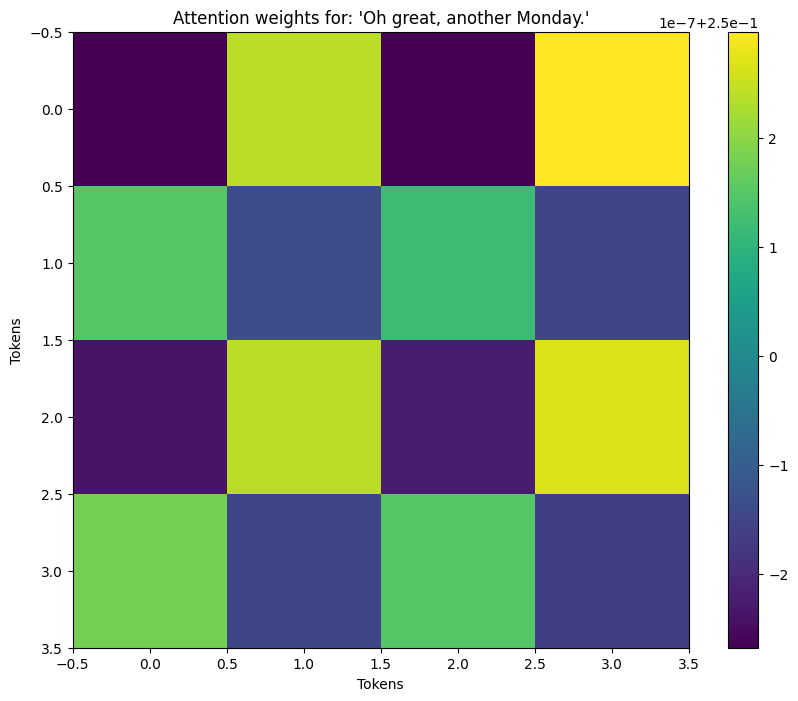

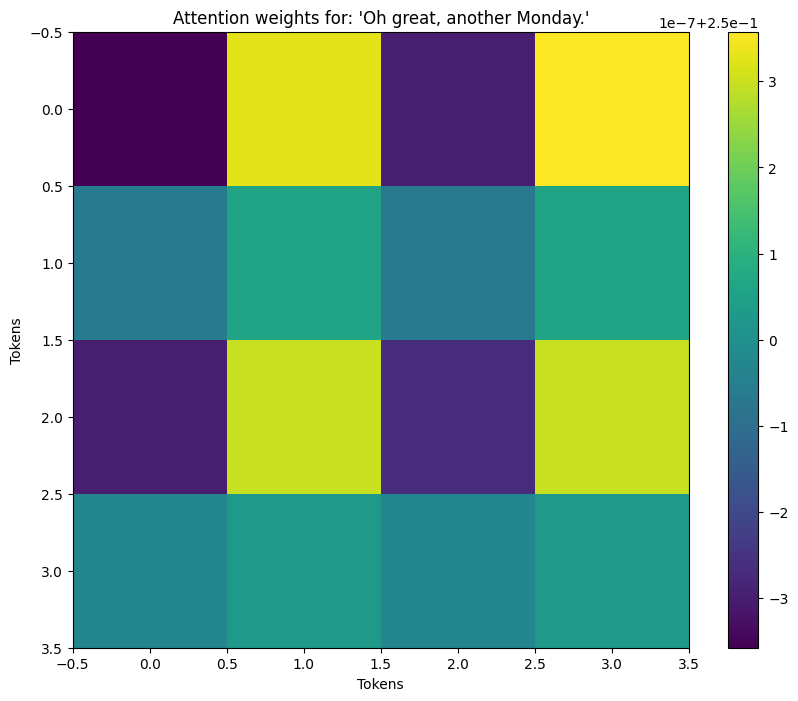

In [13]:

# Visualize Attention Weights
def visualize_attention(inputs, attention_weights, input_text):
    attention_weights = tf.reduce_mean(attention_weights, axis=1).numpy().squeeze()  # Average over heads and squeeze batch

    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, cmap='viridis')
    plt.colorbar()
    plt.title(f"Attention weights for: '{input_text}'")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()

# Select a manual test input to visualize attention
selected_text = "Oh great, another Monday."
selected_sequence = tf.constant(tf.keras.preprocessing.sequence.pad_sequences(
    [map_to_word2vec_indices(selected_text, word_index_map)], maxlen=len(selected_text.split()), padding='post'))

# Pass through transformer blocks and visualize attention
_, attn_weights1 = transformer_block1(embedding_layer(selected_sequence))
visualize_attention(selected_sequence, attn_weights1, selected_text)

_, attn_weights2 = transformer_block2(embedding_layer(selected_sequence))
visualize_attention(selected_sequence, attn_weights2, selected_text)

_, attn_weights3 = transformer_block3(embedding_layer(selected_sequence))
visualize_attention(selected_sequence, attn_weights3, selected_text)
